<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#MCD43" data-toc-modified-id="MCD43-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>MCD43</a></span></li><li><span><a href="#Processing" data-toc-modified-id="Processing-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Processing</a></span><ul class="toc-item"><li><span><a href="#MCD43A3" data-toc-modified-id="MCD43A3-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>MCD43A3</a></span></li><li><span><a href="#Data-prep" data-toc-modified-id="Data-prep-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Data prep</a></span><ul class="toc-item"><li><span><a href="#Define-SRS" data-toc-modified-id="Define-SRS-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Define SRS</a></span></li><li><span><a href="#Permute-x-and-y" data-toc-modified-id="Permute-x-and-y-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>Permute x and y</a></span></li><li><span><a href="#Flatten-and-transform" data-toc-modified-id="Flatten-and-transform-2.2.3"><span class="toc-item-num">2.2.3&nbsp;&nbsp;</span>Flatten and transform</a></span></li><li><span><a href="#Reshape" data-toc-modified-id="Reshape-2.2.4"><span class="toc-item-num">2.2.4&nbsp;&nbsp;</span>Reshape</a></span></li></ul></li><li><span><a href="#Check-spatial-references" data-toc-modified-id="Check-spatial-references-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Check spatial references</a></span></li><li><span><a href="#MCD43A1" data-toc-modified-id="MCD43A1-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>MCD43A1</a></span><ul class="toc-item"><li><span><a href="#Intro" data-toc-modified-id="Intro-2.4.1"><span class="toc-item-num">2.4.1&nbsp;&nbsp;</span>Intro</a></span></li><li><span><a href="#Data-prep" data-toc-modified-id="Data-prep-2.4.2"><span class="toc-item-num">2.4.2&nbsp;&nbsp;</span>Data prep</a></span></li><li><span><a href="#SZN" data-toc-modified-id="SZN-2.4.3"><span class="toc-item-num">2.4.3&nbsp;&nbsp;</span>SZN</a></span></li><li><span><a href="#Quality-flags" data-toc-modified-id="Quality-flags-2.4.4"><span class="toc-item-num">2.4.4&nbsp;&nbsp;</span>Quality flags</a></span></li><li><span><a href="#Albedo" data-toc-modified-id="Albedo-2.4.5"><span class="toc-item-num">2.4.5&nbsp;&nbsp;</span>Albedo</a></span></li><li><span><a href="#Black-sky-albedo" data-toc-modified-id="Black-sky-albedo-2.4.6"><span class="toc-item-num">2.4.6&nbsp;&nbsp;</span>Black sky albedo</a></span></li><li><span><a href="#White-sky-albedo" data-toc-modified-id="White-sky-albedo-2.4.7"><span class="toc-item-num">2.4.7&nbsp;&nbsp;</span>White sky albedo</a></span></li><li><span><a href="#Blue-sky-albedo" data-toc-modified-id="Blue-sky-albedo-2.4.8"><span class="toc-item-num">2.4.8&nbsp;&nbsp;</span>Blue sky albedo</a></span></li></ul></li></ul></li><li><span><a href="#scratch" data-toc-modified-id="scratch-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>scratch</a></span></li></ul></div>

# MCD43 Albedos for Florida USGS 2018 Evapotranspiration Model Runs
This notebook documents the process for calculating the black, white, and blue sky albedos for Shoemaker et al. 2018 (USGS). Take care of imports first:

In [2]:
%matplotlib inline

## plotting only -->>
import cartopy.feature as feat
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('font', **{
    'family': 'normal', 
    'weight': 'normal', 
    'size': 16})

## processing -->>
from pyproj import Proj, transform
import xarray as xr     
import numpy as np 
import datetime
import sys

## MCD43

The HDFs for MCD43A1 are unwieldy and we only need six of the ~20 layers so I requested subsets from APPEEARS in netCDF format. Visit [this document](data/RequestMCD43A3.md) for instructions on how to requests identical subsets using the JSON request records included in this repo.

I requested both MCD43A1 and MCD43A3 for Florida for 2018 instead of just MCD43A1 for reasons that I'll explain later. Each products has the data for the whole year in a single netCDF:
* MCD43A1: [data\MCD43A1.006_500m_aid0001.nc](data\MCD43A1.006_500m_aid0001.nc)
* MCD43A3: [data\MCD43A3.006_500m_aid0001.nc](data\MCD43A3.006_500m_aid0001.nc)

## Processing 

### MCD43A3

MCD43A3 has black- and white-sky albedo calculated for local solar noon observations only, so it resembles a piece of our result.

Open the dataset for MCD43A3 with `xr.open_dataset`:

In [3]:
netcdf = "data/MCD43A3.006_500m_aid0001.nc"

ds = xr.open_dataset(netcdf) # open to xr.Dataset struct
ds = ds.rename({"xdim": "x", "ydim": "y"}) # rename dims x,y to stndrd

ds

<xarray.Dataset>
Dimensions:                                       (time: 365, x: 1336, y: 1555)
Coordinates:
  * time                                          (time) object 2018-01-01 00:00:00 ... 2018-12-31 00:00:00
  * y                                             (y) float64 3.447e+06 ... 2.727e+06
  * x                                             (x) float64 -8.404e+06 ... -7.785e+06
Data variables:
    crs                                           int8 ...
    Albedo_BSA_nir                                (time, y, x) float32 ...
    Albedo_BSA_shortwave                          (time, y, x) float32 ...
    Albedo_BSA_vis                                (time, y, x) float32 ...
    Albedo_WSA_nir                                (time, y, x) float32 ...
    Albedo_WSA_shortwave                          (time, y, x) float32 ...
    Albedo_WSA_vis                                (time, y, x) float32 ...
    BRDF_Albedo_Band_Mandatory_Quality_nir        (time, y, x) float32 ...
    BRDF

Notice the data are conveniently organized along three dimensions *time, x, y*.

### Data prep
Make a few more improvements to the structure of the dataset:
* Add two-dimensional arrays (2) of lat and lon values to improve spatial metadata
* Assign some additional metadata about the quality flags information to the *Mandatory_Quality* variables
* etc.

We need latitudes and longitudes to calculate the solar zenith angle, so use `numpy` and `proj` libraries to generate arrays of lat,lon equivalents for the *x, y* coordinates in the dataset. A few steps are required:

#### Define SRS
Define spatial information for the source x,y arrays and the target lon,lat arrays using `pyproj.Proj`

In [4]:
ds.crs

<xarray.DataArray 'crs' ()>
array(-127, dtype=int8)
Attributes:
    grid_mapping_name:                      sinusoidal
    _CoordinateAxisTypes:                   GeoX GeoY
    semi_major_axis:                        6371007.181
    semi_minor_axis:                        6371007.181
    longitude_of_central_meridian:          0
    longitude_of_projection_origin:         0
    straight_vertical_longitude_from_pole:  0
    false_easting:                          0
    false_northing:                         0

I'm not aware of any geoscience application where sinusoidal coordinates are reference to an origin other than lat==0, lon==0. So, this piece is unnecessary, but it stays for the sake of provenance.

I only used the lambda `getpar` to avoid having too many columns. The mess below is assembling the attributes from `ds.crs` into the proj4 string to be consumed by `pyproj.Proj`. Use the EPSG code for WGS84:

In [5]:
getpar = lambda a: str(ds.crs.attrs[a])

inproj = Proj(" ".join([
    "+proj=sinu",
    "+lon_0="+getpar("longitude_of_central_meridian"),
    "+x_0="+getpar("false_easting"),
    "+y_0="+getpar("false_northing"),
    "+a="+getpar("semi_major_axis"),
    "+b="+getpar("semi_minor_axis"),
    "+units="+"meter +no_defs"]))

outproj = Proj(init="epsg:4326")

inproj

pyproj.Proj('+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs ', preserve_units=True)

#### Permute x and y
After we expand **x** and **y** to two dimensions, we need immediately flatten them so when they're taken together they represent a sequence of latitude longitude pairs that enumerate over all pixels from top-left to bottom-right of the dataset. 

You can do this with `numpy.meshgrid` then `numpy.array.flatten`. Use `numpy.meshgrid` first:

In [6]:
xx, yy = np.meshgrid(ds.x.data, ds.y.data)

xx

array([[-8403797.7087391 , -8403334.39602257, -8402871.08330604, ...,
        -7786201.85760757, -7785738.54489104, -7785275.23217452],
       [-8403797.7087391 , -8403334.39602257, -8402871.08330604, ...,
        -7786201.85760757, -7785738.54489104, -7785275.23217452],
       [-8403797.7087391 , -8403334.39602257, -8402871.08330604, ...,
        -7786201.85760757, -7785738.54489104, -7785275.23217452],
       ...,
       [-8403797.7087391 , -8403334.39602257, -8402871.08330604, ...,
        -7786201.85760757, -7785738.54489104, -7785275.23217452],
       [-8403797.7087391 , -8403334.39602257, -8402871.08330604, ...,
        -7786201.85760757, -7785738.54489104, -7785275.23217452],
       [-8403797.7087391 , -8403334.39602257, -8402871.08330604, ...,
        -7786201.85760757, -7785738.54489104, -7785275.23217452]])

#### Flatten and transform
Flatten and transform the expanded 2d arrays and pass them as arguments 3 and 4 to `pyproj.transform` to get lon,lat pairs:

In [7]:
lon1d, lat1d = transform(
    inproj, 
    outproj, 
    xx.flatten(), 
    yy.flatten())

print("First five (lon,lat) pairs:"); list(zip(lon1d[:5], lat1d[:5]))

First five (lon,lat) pairs:


[(-88.17267591715559, 31.002083330549265),
 (-88.16781483846015, 31.002083330549265),
 (-88.16295375976472, 31.002083330549265),
 (-88.15809268106929, 31.002083330549265),
 (-88.15323160237384, 31.002083330549265)]

#### Reshape
Reshape the new lon,lat arrays to match the original shape of the 2d x (`xx`) and y (`yy`) arrays. The **latitude** and **longitude** variables in the final dataset will be arranged along the **x** and **y** dimensions (both are 1d), so that every sinusoidal pixel is assigned a geographic reference:

In [8]:
lon2d, lat2d = lon1d.reshape(xx.shape), lat1d.reshape(yy.shape)

lat2d

array([[31.00208333, 31.00208333, 31.00208333, ..., 31.00208333,
        31.00208333, 31.00208333],
       [30.99791666, 30.99791666, 30.99791666, ..., 30.99791666,
        30.99791666, 30.99791666],
       [30.99375   , 30.99375   , 30.99375   , ..., 30.99375   ,
        30.99375   , 30.99375   ],
       ...,
       [24.53541666, 24.53541666, 24.53541666, ..., 24.53541666,
        24.53541666, 24.53541666],
       [24.53125   , 24.53125   , 24.53125   , ..., 24.53125   ,
        24.53125   , 24.53125   ],
       [24.52708333, 24.52708333, 24.52708333, ..., 24.52708333,
        24.52708333, 24.52708333]])

Now we can add them to our dataset add two additional coordinate variables by creating an `xr.DataArray` for each and adding them to the dataset. This gets us closer to full compliance with CF recommendations:

In [9]:
ds.coords["lat"] = xr.DataArray(
    data=lat2d, 
    coords=[ds.y, ds.x], 
    dims=["y", "x"], 
    attrs=dict(
        standard_name="latitude",
        long_name="latitude coordinate",
        units="degrees_north"))

ds.coords["lon"] = xr.DataArray(
    data=lon2d, 
    coords=[ds.y, ds.x], 
    dims=["y", "x"], 
    attrs=dict(
        standard_name="longitude",
        long_name="longitude coordinate",
        units="degrees_east"))

ds

<xarray.Dataset>
Dimensions:                                       (time: 365, x: 1336, y: 1555)
Coordinates:
  * time                                          (time) object 2018-01-01 00:00:00 ... 2018-12-31 00:00:00
  * y                                             (y) float64 3.447e+06 ... 2.727e+06
  * x                                             (x) float64 -8.404e+06 ... -7.785e+06
    lat                                           (y, x) float64 31.0 ... 24.53
    lon                                           (y, x) float64 -88.17 ... -76.96
Data variables:
    crs                                           int8 -127
    Albedo_BSA_nir                                (time, y, x) float32 ...
    Albedo_BSA_shortwave                          (time, y, x) float32 ...
    Albedo_BSA_vis                                (time, y, x) float32 ...
    Albedo_WSA_nir                                (time, y, x) float32 ...
    Albedo_WSA_shortwave                          (time, y, x) float3

### Check spatial references

It's probably a good idea to do more thorough review to make sure there are no mistakes. You can do a lot of indexing and stats calculation in a single line of code. But break it out into a couple distinct steps:
1. select the **black-sky albedo** variable
2. plot the first timestep with `cartopy`
3. plot the **gridded averages by month**
4. plot a single line for the daily time series over all of Florida

**Select BSA:**

In [10]:
bsa = ds["Albedo_BSA_nir"]; bsa    # select the BSA

<xarray.DataArray 'Albedo_BSA_nir' (time: 365, y: 1555, x: 1336)>
[758280200 values with dtype=float32]
Coordinates:
  * time     (time) object 2018-01-01 00:00:00 ... 2018-12-31 00:00:00
  * y        (y) float64 3.447e+06 3.447e+06 3.446e+06 ... 2.728e+06 2.727e+06
  * x        (x) float64 -8.404e+06 -8.403e+06 ... -7.786e+06 -7.785e+06
    lat      (y, x) float64 31.0 31.0 31.0 31.0 31.0 ... 24.53 24.53 24.53 24.53
    lon      (y, x) float64 -88.17 -88.17 -88.16 -88.16 ... -76.97 -76.96 -76.96
Attributes:
    grid_mapping:      crs
    valid_min:         0
    valid_max:         32767
    long_name:         Albedo_BSA_nir
    units:             reflectance, no units
    scale_factor_err:  0.0
    add_offset_err:    0.0
    calibrated_nt:     5

**Plot the first timestep:**

C:\Apps\Python\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


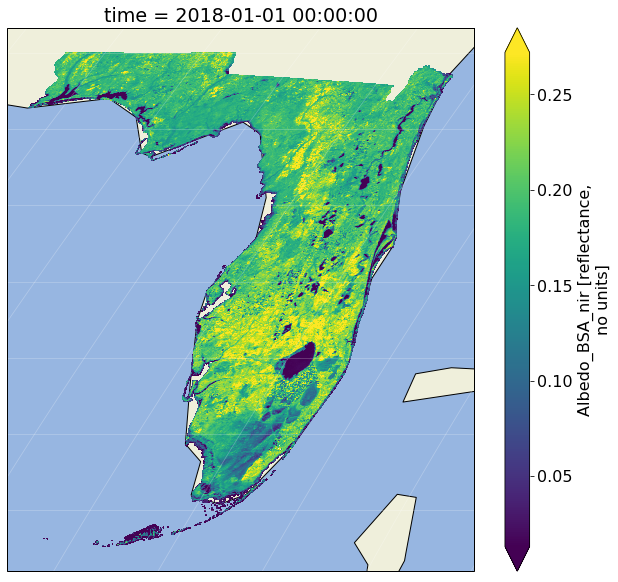

In [11]:
fig = plt.figure(figsize=(11, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Sinusoidal.MODIS)
bsa.isel(time=0).plot.pcolormesh(x="x", y="y", ax=ax, robust=True,)

# optional, aesthetics -->>
ax.set_yticklabels([]); ax.set_xticklabels([]);
ax.add_feature(feat.OCEAN, zorder=0);
ax.add_feature(feat.LAND, zorder=0, edgecolor='black');
ax.gridlines(color="white", alpha=0.25); #ax.set_global();

**Plot monthly gridded averages:**

C:\Apps\Python\Anaconda3\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


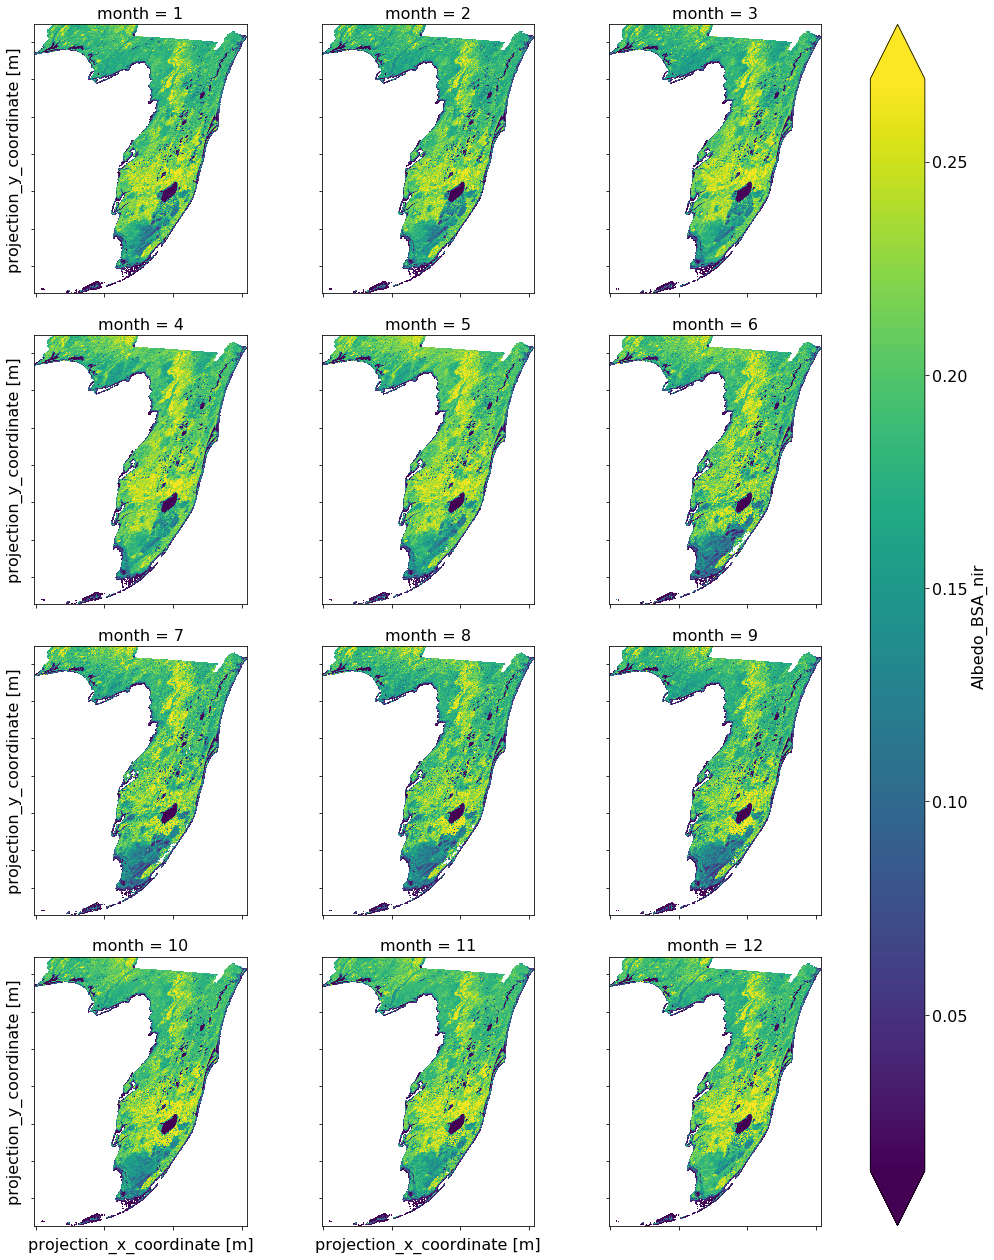

In [12]:
bsamo = bsa.groupby(bsa.time.dt.month).mean("time")
bsamo.plot.pcolormesh(
    x='x', 
    y='y', 
    col='month', 
    col_wrap=3, 
    robust=True, 
    figsize=(16, 18))
ax = plt.gca()
ax.set_yticklabels([]); ax.set_xticklabels([]);
ax.set_ylabel(""); ax.set_xlabel("");

**The daily average of BSA over the state of Florida for 2018:**

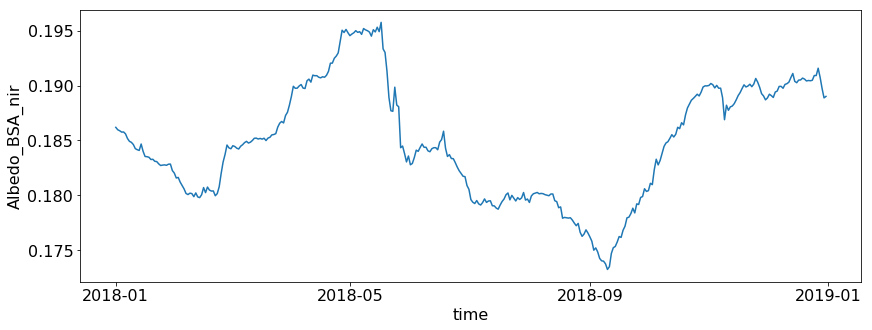

In [13]:
bsa.mean(["x","y"]).plot(x="time", figsize=(14, 5))

### MCD43A1

The MODIS BRDF/Albedo/NBAR product (MCD43) is led by [Professor Crystal Schaaf at UMass Boston](https://www.umb.edu/spectralmass/terra_aqua_modis/modis_brdf_albedo_product_mcd43). The albedo [source code](proc/actual_albedo_tool/actual_albedo_tool.tar.gz) maintained by her lab are accessible at her [ftp site](ftp://rsftp.eeos.umb.edu/data01/Website/actual_albedo_tool.tar.gz). The [readme](proc/actual_albedo_tool/albedo/readme) is the source of most of the `block text` in the notebook.



#### Intro

#### Data prep

In [14]:
ds = xr.open_dataset("data/MCD43A1.006_500m_aid0001.nc")
ds = ds.rename({
    "Num_Parameters": "param", 
    "xdim": "x", 
    "ydim": "y"})

ds

<xarray.Dataset>
Dimensions:                                       (param: 3, time: 365, x: 1336, y: 1555)
Coordinates:
  * time                                          (time) object 2018-01-01 00:00:00 ... 2018-12-31 00:00:00
  * y                                             (y) float64 3.447e+06 ... 2.727e+06
  * x                                             (x) float64 -8.404e+06 ... -7.785e+06
  * param                                         (param) int32 0 1 2
Data variables:
    crs                                           int8 ...
    BRDF_Albedo_Band_Mandatory_Quality_nir        (time, y, x) float32 ...
    BRDF_Albedo_Band_Mandatory_Quality_shortwave  (time, y, x) float32 ...
    BRDF_Albedo_Band_Mandatory_Quality_vis        (time, y, x) float32 ...
    BRDF_Albedo_Parameters_nir                    (time, y, x, param) float32 ...
    BRDF_Albedo_Parameters_shortwave              (time, y, x, param) float32 ...
    BRDF_Albedo_Parameters_vis                    (time, y, x, p

Use the same coordinates as MCD43A3:

In [15]:
latatts = dict(
    standard_name="latitude",
    long_name="latitude coordinate",
    units="degrees_north")

ds.coords["lat"] = xr.DataArray(
    data=lat2d, 
    coords=[ds.y, ds.x], 
    dims=["y", "x"], 
    attrs=latatts)

lonatts = dict(
    standard_name="longitude",
    long_name="longitude coordinate",
    units="degrees_east")

ds.coords["lon"] = xr.DataArray(
    data=lon2d, 
    coords=[ds.y, ds.x], 
    dims=["y", "x"], 
    attrs=lonatts)

ds

<xarray.Dataset>
Dimensions:                                       (param: 3, time: 365, x: 1336, y: 1555)
Coordinates:
  * time                                          (time) object 2018-01-01 00:00:00 ... 2018-12-31 00:00:00
  * y                                             (y) float64 3.447e+06 ... 2.727e+06
  * x                                             (x) float64 -8.404e+06 ... -7.785e+06
  * param                                         (param) int32 0 1 2
    lat                                           (y, x) float64 31.0 ... 24.53
    lon                                           (y, x) float64 -88.17 ... -76.96
Data variables:
    crs                                           int8 ...
    BRDF_Albedo_Band_Mandatory_Quality_nir        (time, y, x) float32 ...
    BRDF_Albedo_Band_Mandatory_Quality_shortwave  (time, y, x) float32 ...
    BRDF_Albedo_Band_Mandatory_Quality_vis        (time, y, x) float32 ...
    BRDF_Albedo_Parameters_nir                    (time, y, x, pa

**Subset for testing:**

In [16]:
ds_jan = ds.isel(time=slice(0,30))
ds_jan

<xarray.Dataset>
Dimensions:                                       (param: 3, time: 30, x: 1336, y: 1555)
Coordinates:
  * time                                          (time) object 2018-01-01 00:00:00 ... 2018-01-30 00:00:00
  * y                                             (y) float64 3.447e+06 ... 2.727e+06
  * x                                             (x) float64 -8.404e+06 ... -7.785e+06
  * param                                         (param) int32 0 1 2
    lat                                           (y, x) float64 31.0 ... 24.53
    lon                                           (y, x) float64 -88.17 ... -76.96
Data variables:
    crs                                           int8 ...
    BRDF_Albedo_Band_Mandatory_Quality_nir        (time, y, x) float32 ...
    BRDF_Albedo_Band_Mandatory_Quality_shortwave  (time, y, x) float32 ...
    BRDF_Albedo_Band_Mandatory_Quality_vis        (time, y, x) float32 ...
    BRDF_Albedo_Parameters_nir                    (time, y, x, par

#### SZN
The only input to black- and white-sky albedos that doesn't come in MCD43A1 is the solar zenith angle (but, you can get it in MCD43A2 if you wish to use local solar noon). 

*needs explanation...*

We have to calculate solar zenith angles for every pixel, for every timestep in the time series (that's a lot, obv). In this next cell, we import `pysolar`, a widely used solar index calculator for Python, and test the `get_altitude` function with the first day in our time series:

In [17]:
from pysolar.solar import *

# get a datetime object for Jan 1 2018
date = datetime.datetime.strptime("2018-01-01", "%Y-%m-%d")

# set the timezone to UTC
date = date.replace(tzinfo=datetime.timezone.utc)

# get the solar zenith angle
alt  = get_altitude(42.206, -71.382, date)

alt

-28.105985638726963

Now run the same function with the datetime for timestep 1 and make sure it matches the angle given above:

In [18]:
# get timestep 1 as a datetime object
timestep1 = ds_jan.time[0].data.item()._to_real_datetime()

# set timezone to utc
timestep1 = timestep1.replace(tzinfo=datetime.timezone.utc)

# get solar zenith angle
alt2 = get_altitude(42.206, -71.382, timestep1)

# check if they are equal
alt==alt2

True

True, success! 

This amounts to 758,280,200 individual calculations (`pixels*timesteps`); it may take 10 minutes or so on a typical workstation:

In [19]:
def sza_eval(lat, lon, time):
    """Convert CF to Python datetime."""
    ts = time.data.item()._to_real_datetime()
    ts = ts.replace(tzinfo=datetime.timezone.utc)
    return(get_altitude(lat, lon, ts))
    
# evaluate sza over all arrays using list comprehension 
sza_arr = np.dstack([sza_eval(lat1d, lon1d, t) for t in ds_jan.time])
sza_arr.shape

(1, 2077480, 30)

Array dimensions look correct. We need to reshape the large axis to match the shape of the raster like we did with our 1d lat and lon coordinates:

In [20]:
sza2d = sza_arr.reshape((1555, 1336, 30))
sza2d.shape

(1555, 1336, 30)

Add the solar zenith angle array to our master dataset as a new variable:

In [21]:
SZA = xr.DataArray(
    data=sza2d, 
    coords=[ds_jan.y, ds_jan.x, ds_jan.time], # note that we reorder coords in
    dims=["y", "x", "time"],                  # dims argument to match others
    attrs=dict(
        units="degree",
        standard_name="solar zenith angle",
        long_name="solar zenith angle"))

SZA = SZA.transpose("time", "y", "x")
SZA

<xarray.DataArray (time: 30, y: 1555, x: 1336)>
array([[[-12.433387, -12.437313, ..., -17.715847, -17.719839],
        [-12.435104, -12.439031, ..., -17.717582, -17.721574],
        ...,
        [-14.561019, -14.564959, ..., -19.847377, -19.851362],
        [-14.562034, -14.565974, ..., -19.848382, -19.852366]],

       [[-12.298321, -12.302248, ..., -17.581535, -17.585526],
        [-12.300041, -12.303968, ..., -17.583272, -17.587264],
        ...,
        [-14.430197, -14.434138, ..., -19.717877, -19.721863],
        [-14.431215, -14.435156, ..., -19.718885, -19.722871]],

       ...,

       [[ -7.992107,  -7.996108, ..., -13.367921, -13.371978],
        [ -7.994113,  -7.998113, ..., -13.369951, -13.374008],
        ...,
        [-10.594768, -10.598791, ..., -15.988462, -15.992524],
        [-10.596105, -10.600129, ..., -15.9898  , -15.993862]],

       [[ -7.821408,  -7.825413, ..., -13.202573, -13.206634],
        [ -7.823432,  -7.827436, ..., -13.204621, -13.208682],
        ...,

#### Quality flags
Reference: https://lpdaac.usgs.gov/products/mcd43a1v006/

Fortunately, MCD43 quality flags are as simple as they come (for MODIS):
```
Value 	Description
0 	    Processed; good quality (full BRDF inversions)
1 	    Processed; see other QA (magnitude BRDF inversions)
2 	    Processed; good quality (full BRDF inversions); Band 6 filled; dead or noisy detectors
3 	    Processed; see other QA (magnitude BRDF inversions); Band 6 filled; dead or noisy detectors
255 	Fill Value
```

We may decide to filter the pixels derived via magnitude BRDF inversions, but for now we will keep all data. They are already weighted to amplify the best observation over a 16 day period.

#### Albedo

Now we finally calculate albedos.

The black-sky albedo polynomial is presented in a more practical way in the readme than the equation given in the user guide:

```shell
$ sed -n '31,53p;53q' proc/actual_albedo_tool/albedo/readme

    Calculation of WSA and BSA
    --------------------------

    The program read the BRDF parameters from out1. Black-sky
    albedos are calculated according to the following polynomial
    albedo representation.
    
                          K=iso       k=vol           k=geo
    G_0k(term 1)           1.0      -0.007574       -1.284909   <- BSA coefficients
    G_1k(term SZN^2)       0.0      -0.070987       -0.166314   <- 
    G_2k(term SZN^3)       0.0       0.307588        0.041840   <- 
    WSA                    1.0       0.189184       -1.377622   <- WSA coefficients

    BSA(SZN,BAND)=
        F_iso(BAND)*(G_0iso + G_1iso*SZN^2 + G_2iso*SZN^3) +
        F_vol(BAND)*(G_0vol + G_1vol*SZN^2 + G_2vol*SZN^3) +
        F_geo(BAND)*(G_0geo + G_1geo*SZN^2 + G_2geo*SNZ^3)

    SZN:  solar zenith angle
    BAND: band wavelength
    OD:   optical depth
    AMT:  aerosol model type
   
```

#### Black sky albedo

Define some functions that do the math above.

We also write a simple function to vectorize each calculation over our giant array. It should run significantly faster than a for loop. We can only vectorize over coordinates with matching dimensions, so we will have to loop over the timesteps.

```python
def vectorized(a, b):
    func = lambda x, y: np.sqrt(x ** 2 + y ** 2)
    return xr.apply_ufunc(func, a, b)
```

In [22]:
iso = lambda sza:  1.0      +  0.0*sza**2      + 0.0*sza**3      # Isotropic
vol = lambda sza: -0.007574 + -0.070987*sza**2 + 0.307588*sza**3 # RossThick
geo = lambda sza: -1.284909 + -0.166314*sza**2 + 0.041840*sza**3 # LiSparseR


def iso_vectorized(par1, sza):
    pfunc = lambda p, s: p*iso(s)
    return(xr.apply_ufunc(pfunc, par1, sza))
   
    
def vol_vectorized(par2, sza):
    pfunc = lambda p, s: p*iso(s)
    return(xr.apply_ufunc(pfunc, par2, sza))


def geo_vectorized(par3, sza):
    pfunc = lambda p, s: p*iso(s)
    return(xr.apply_ufunc(pfunc, par3, sza))

Test like so:

C:\Apps\Python\Anaconda3\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


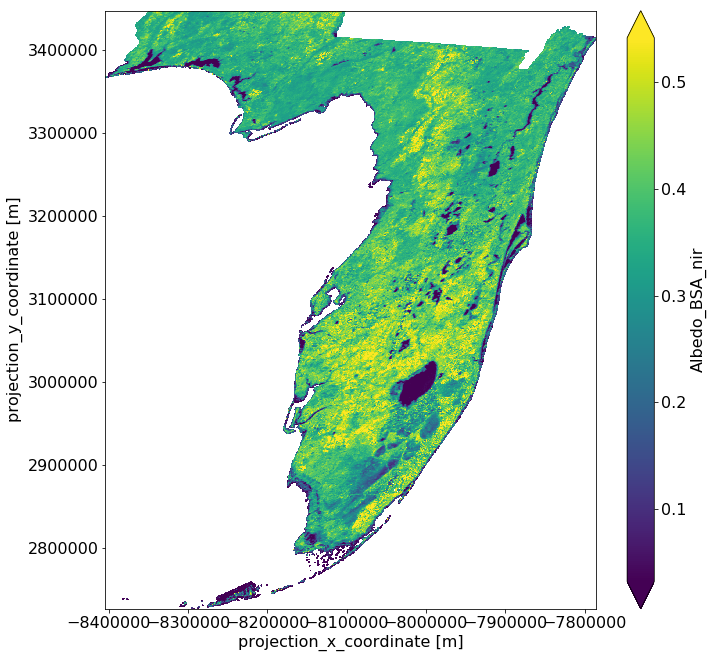

In [46]:
nir = ds_jan["BRDF_Albedo_Parameters_nir"]

nir_par1 = nir.sel(param=0)
nir_par2 = nir.sel(param=1)
nir_par3 = nir.sel(param=2)

iso_nir = iso_vectorized(nir_par1, SZA)
vol_nir = vol_vectorized(nir_par2, SZA)
geo_nir = geo_vectorized(nir_par3, SZA)

bsa_jan = iso_nir+vol_nir+geo_nir
bsa_jan = bsa_jan.drop("param")

bsa_jan.name = "Albedo_BSA_nir"
bsa_jan.attrs = dict(
    _FillValue=32767,
    coordinates="time y x",
    grid_mapping="crs",
    valid_min=0,
    valid_max=32766,
    long_name="Albedo_BSA_nir",
    units="reflectance, no units",
    scale_factor_err=0.0,
    add_offset_err=0.0,
    calibrated_nt=5,
    scale_factor=0.001,
    add_offset=0.0)

bsa_jan.mean("time").plot.pcolormesh(x='x', y='y', robust=True, figsize=(11,11),)

#### White sky albedo

```
                          K=iso       k=vol           k=geo
    WSA                    1.0       0.189184       -1.377622   <- WSA coefficients

```

C:\Apps\Python\Anaconda3\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


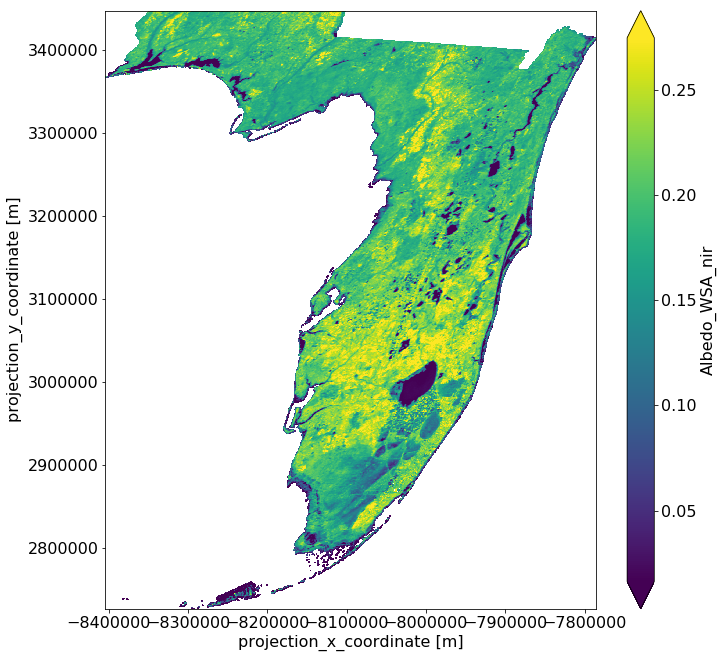

In [47]:
def wsa_vectorized(par1, par2, par3):
    """ """
    iso, vol, geo = 1.0, 0.189184, -1.377622
    pfunc = lambda p1, p2, p3: (p1*iso + p2*vol + p3*geo)
    return(xr.apply_ufunc(pfunc, par1, par2, par3))

wsa_jan = wsa_vectorized(nir_par1, nir_par2, nir_par3)
wsa_jan.name = "Albedo_WSA_nir"
wsa_jan.attrs = dict(
    _FillValue=32767,
    coordinates="time y x",
    grid_mapping="crs",
    valid_min=0,
    valid_max=32766,
    long_name="Albedo_WSA_nir",
    units="reflectance, no units",
    scale_factor_err=0.0,
    add_offset_err=0.0,
    calibrated_nt=5,
    scale_factor=0.001,
    add_offset=0.0)

wsa_jan.mean("time").plot.pcolormesh(x='x', y='y', robust=True, figsize=(11,11),)

#### Blue sky albedo

You sum them to get black-sky albedo. Vectorize the entire operation for BSA and run it:

In [ ]:
def bsa(band, sza):
    """Vectorize albedo polynomials over two 3d arrays."""
    
    bsafunc = lambda band, sza: (
        iso_vectorized(band.sel(param=0), sza)+
        vol_vectorized(band.sel(param=1), sza)+
        geo_vectorized(band.sel(param=2), sza))
    
    return(xr.apply_ufunc(bsafunc, band, sza))

BSA = bsa(ds_jan["BRDF_Albedo_Parameters_nir"], SZA)
BSA

In [ ]:
iso_nir.isel(time=0).plot.pcolormesh(x='x', y='y')

In [ ]:
nir_input1.

`bsa_vectorized` is the heavy-lifter. We use it to apply the functions (iso, vol, geo) over two billion times.

In [ ]:
def bsa_vectorize(band):
    """Vectorize albedo polynomials over two 3d arrays."""
    
    p1 = lambda par,sza: par*iso(par, sza)
    p2 = lambda par,sza: par*vol(par, sza)
    p3 = lambda par,sza: par*geo(par, sza)
    
    func = lambda p,s : poly(p, s)
    
    return(xr.apply_ufunc(func, par, sza))

bsa_vectorized(iso, par1, ds["SZA"])




## scratch
**Collect some notes and bits of code here**

<img src="http://docs.pysolar.org/en/latest/_images/reference_frame.png" alt="alt text" width="500px">    
*source: [http://docs.pysolar.org/en/latest/#location-calculation](http://docs.pysolar.org/en/latest/#location-calculation)*


In [ ]:
import cartopy.crs as ccrs

bsa.plot.pcolormesh(
    x='x', 
    y='y', 
    col='month', 
    col_wrap=3, 
    robust=True, 
    figsize=(16,18),
    #transform=ccrs.Sinusoidal(),
    #subplot_kws={'projection': ccrs.Sinusoidal(-82, 28)}
)

ax.set_yticklabels([])
ax.set_xticklabels([])

This binary computes black, white, blue sky albedos from input BRDF parameters from MCD43A1 (HDF):
* 
[/code/albedo/actual_albedo_hdf.exe](./code/albedo/actual_albedo_hdf.exe)

```shell

$ ./code/albedo/actual_albedo_hdf.exe

Usage: actual_albedo.exe [-par][-od][-szn][-out]

   -par <par_file>      input MCD43A1 (V005 or V006, in HDF format)
   -od  <optical_depth> input optical depth (float, range: 0.0-1.0)
   -szn <solar_zenith>  input solar zenith angle you want to compute
                        (float, range: 0.0-89.0 degrees)
   -out <albedo_file>   output file to save actual albedo (in HDF format)

```

In [ ]:
import cartopy.crs as ccrs

bsamo.plot.pcolormesh(
    'xdim', 
    'ydim', 
    col='month', 
    col_wrap=3, 
    robust=True, 
    figsize=(16,18),
    #transform=ccrs.Sinusoidal(),
    #subplot_kws={'projection': ccrs.Sinusoidal(-82, 28)}
)

ax.set_yticklabels([])
ax.set_xticklabels([])

**Notes from the R implementation in my other repo**

```R
#####################################################################################
# These functions are called by the loop function in main_albedo.R
#
#::METHODS::
# 
#   https://modis.ornl.gov/documentation.html
#   https://www.umb.edu/spectralmass/terra_aqua_modis/modis_brdf_albedo_product_mcd43
#
# Black-sky Albedo = 
#   Parameters_01 + 
#   Parameters_02 * (-0.007574 + (-0.070987 * szn^2) + (0.307588 * szn^3)) + 
#   Parameters_03 * (-1.284909 + (-0.166314 * szn^2) + (0.041840 * szn^3))
#
# White-sky Albedo = 
#   Parameters_01 + 
#   Parameters_02 * (0.189184) + 
#   Parameters_03 * (-1.377622) 
#
# Actual (Blue-sky) Albedo = 
#   White-sky Albedo * f(optical depth, solar zenith angle, aerosol type, band) + 
#   Black-sky Albedo * (1 - f(optical depth, solar zenith angle, aerosol type, band)) 
#
#####################################################################################
# Albedo calculation constants
#####################################################################################

## Black sky constants

# Isotropic constant
g0iso <- 1.0
g1iso <- 0.0
g2iso <- 0.0

# RossThick constant
g0vol <- -0.007574
g1vol <- -0.070987
g2vol <- 0.307588

# LiSparseR constant
g0geo <- -1.284909
g1geo <- -0.166314
g2geo <- 0.041840

## White sky constants

gIso <- 1.0       # Isotropic
gVol <- 0.189184  # RossThick
gGeo <- -1.377622 # LiSparseR

#####################################################################################
# Albedo functions
#####################################################################################

# Convert SZN degrees to radians
Deg2Rad = 3.1415926535/180
SF = 1 # Scale factor (0.001) already applied to values by ncdf4. Set to 1.

# Black-sky albedo formula
BlackSA <- function(p1arr, p2arr, p3arr, szn){
  sznrad = szn*Deg2Rad
  return((p1arr*SF)+(p2arr*SF)*(g0vol+(g1vol*sznrad^2)+(g2vol*sznrad^3))+(p3arr*SF)*(g0geo+(g1geo*sznrad^2)+(g2geo*sznrad^3)))
}

# White-sky albedo formula
WhiteSA <- function(p1arr, p2arr, p3arr){
  return((p1arr*SF)*gIso+(p2arr*SF)*gVol+(p3arr*SF)*+gGeo)
}

# Actual albedo formula
ActualSA <- function(WSA, BSA, LUTVal){
  return((WSA*LUTVal)+(BSA*(1-LUTVal)))
}

#####################################################################################
# Lookup tables
#####################################################################################

LUT <- function(band, szn, sod){
  if(band == 'vis'){
    return(vislut[paste('X', sprintf('%.2f', sod), sep = ''),round(abs(szn), digits = 0)+1])
  }
  if(band == 'nir'){
    return(nirlut[paste('X', sprintf('%.2f', sod), sep = ''),round(abs(szn), digits = 0)+1])
  }
  if(band == 'shortwave'){
    return(swlut[paste('X', sprintf('%.2f', sod), sep = ''),round(abs(szn), digits = 0)+1])
  }
}
```